In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.initializers import lecun_normal
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



In [81]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [82]:
X, y = df[['Glucose', 'BMI']], df['Outcome']

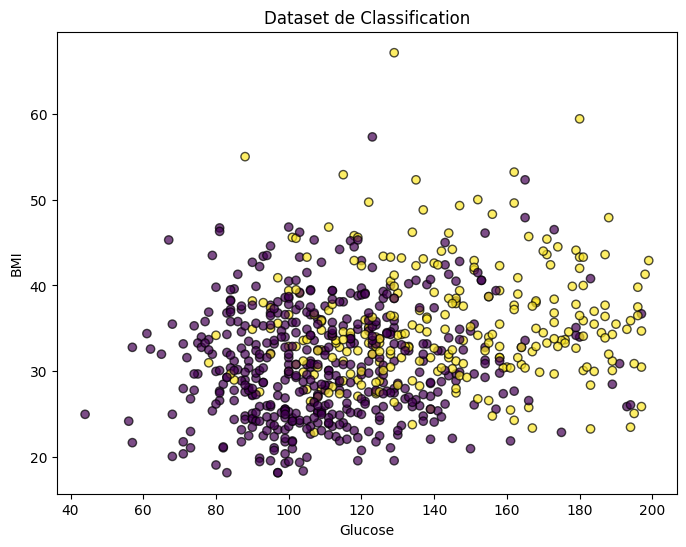

In [83]:
# Filtrer les échantillons où 'Glucose' et 'BMI' ne sont pas égaux à 0
mask = (X['Glucose'] != 0) & (X['BMI'] != 0)

# Appliquer le masque à X et y
X = X[mask].values
y = y[mask].values

# Visualiser le dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("Dataset de Classification")
plt.xlabel("Glucose")
plt.ylabel("BMI")
plt.show()

In [84]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [85]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
    

model_MC = Sequential([InputLayer(input_shape=(2,)),
             MCDropout(0.4),
			 Dense(128, activation="selu", kernel_initializer="lecun_normal"),
             MCDropout(0.4),
             Dense(64, activation="selu", kernel_initializer="lecun_normal"),
             MCDropout(0.4),
             Dense(1, activation=None)
			 ])

/users/eleves-b/2024/ahmed.khairaldin/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [86]:
model_MC.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 optimizer="Nadam",
                 metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [87]:
history_MC = model_MC.fit(X_norm, y, epochs=200, validation_split=0.2, callbacks=[callback])

Epoch 1/200


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6371 - loss: 0.9315 - val_accuracy: 0.6887 - val_loss: 0.7615
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6433 - loss: 0.8320 - val_accuracy: 0.6755 - val_loss: 0.6732
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6770 - loss: 0.6685 - val_accuracy: 0.6159 - val_loss: 0.7715
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6903 - loss: 0.7743 - val_accuracy: 0.6821 - val_loss: 0.7131
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6575 - loss: 0.7054 - val_accuracy: 0.7152 - val_loss: 0.6400
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7177 - loss: 0.6602 - val_accuracy: 0.6755 - val_loss: 0.6580
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7102 - loss: 0.6517 - val_accuracy: 0.7020 - val_loss: 0.6733
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6734 - loss: 0.6621 - val_accuracy: 0.7086 - val_loss: 0.6

In [88]:
# weight adjustment due to dropout
WEIGHTS = model_MC.get_weights()
WEIGHTS[0] *= 1/0.4
model_MC.set_weights(WEIGHTS)

y_pred_stack = np.stack([model_MC.predict(X_norm) for sample in range(10)])

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


In [89]:
# Définir les limites de la grille en fonction de tes données (en supposant X est un numpy array avec 2 features)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
data_meshgrid = np.c_[xx.ravel(), yy.ravel()]

model_MC(data_meshgrid).numpy().reshape(xx.shape)

array([[ 1.8395934e+02,  9.1352510e+00,  2.6823214e+01, ...,
         4.5668008e+02, -4.2627078e-01,  1.4080703e+01],
       [ 1.6621141e+01,  7.7886589e+01, -5.7588488e-01, ...,
         2.1145238e+02,  4.6509921e+02, -6.9263161e+01],
       [ 9.5829210e+00, -5.1925778e-01,  3.8501411e+01, ...,
         2.9379980e+02,  5.4120203e+02,  1.7806642e+02],
       ...,
       [-7.4067564e+00,  7.3615639e+01,  5.4837341e+01, ...,
         8.9202942e+01, -3.6005145e-01,  3.7372430e+02],
       [-5.4579365e-01, -4.7840285e-01,  3.2213982e+01, ...,
         3.9711328e+02, -5.4466730e-01,  3.7216150e+02],
       [ 2.0031549e+01, -5.7217050e-01,  7.7206924e+01, ...,
         4.4488144e+02,  6.1184338e+02,  3.2183098e+01]], dtype=float32)

In [90]:
probabilities = tf.sigmoid(y_pred_stack)
pred_classes = (probabilities > 0.5).numpy().astype(int)



24973/24973 ━━━━━━━━━━━━━━━━━━━━ 7s 276us/step
tf.Tensor(
[[1.        ]
 [1.        ]
 [0.37508053]
 ...
 [1.        ]
 [1.        ]
 [0.3608355 ]], shape=(799130, 1), dtype=float32)


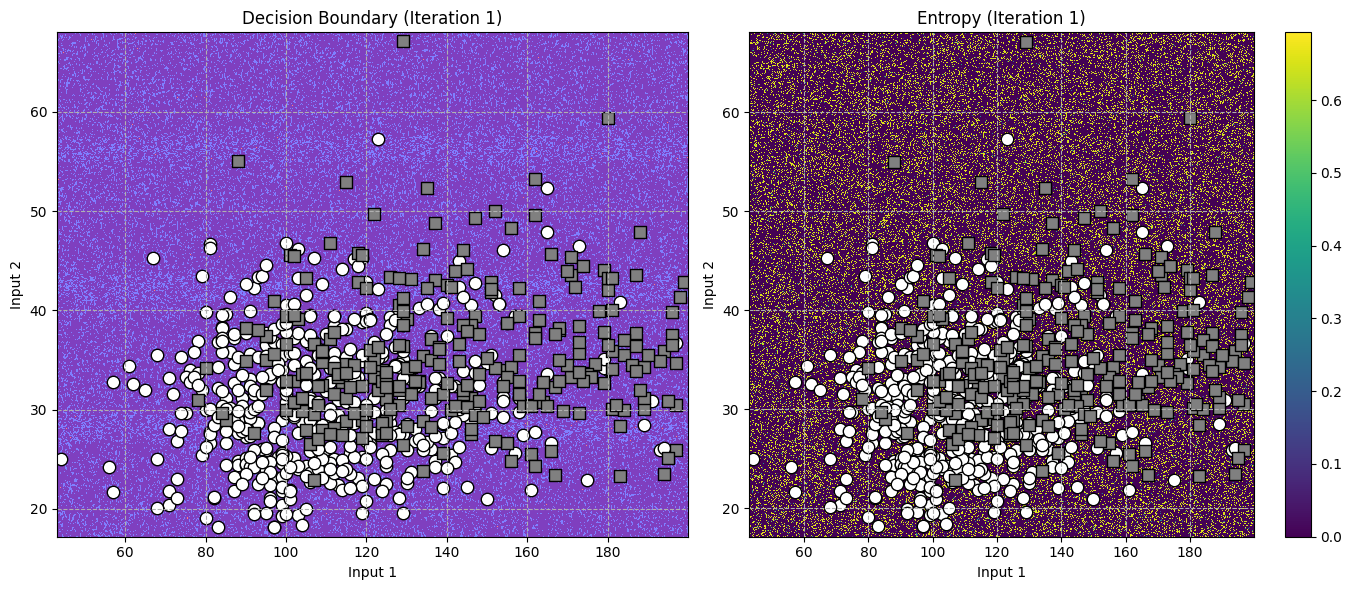

24973/24973 ━━━━━━━━━━━━━━━━━━━━ 7s 263us/step
tf.Tensor(
[[1.        ]
 [0.0022995 ]
 [0.36594307]
 ...
 [1.        ]
 [1.        ]
 [1.        ]], shape=(799130, 1), dtype=float32)


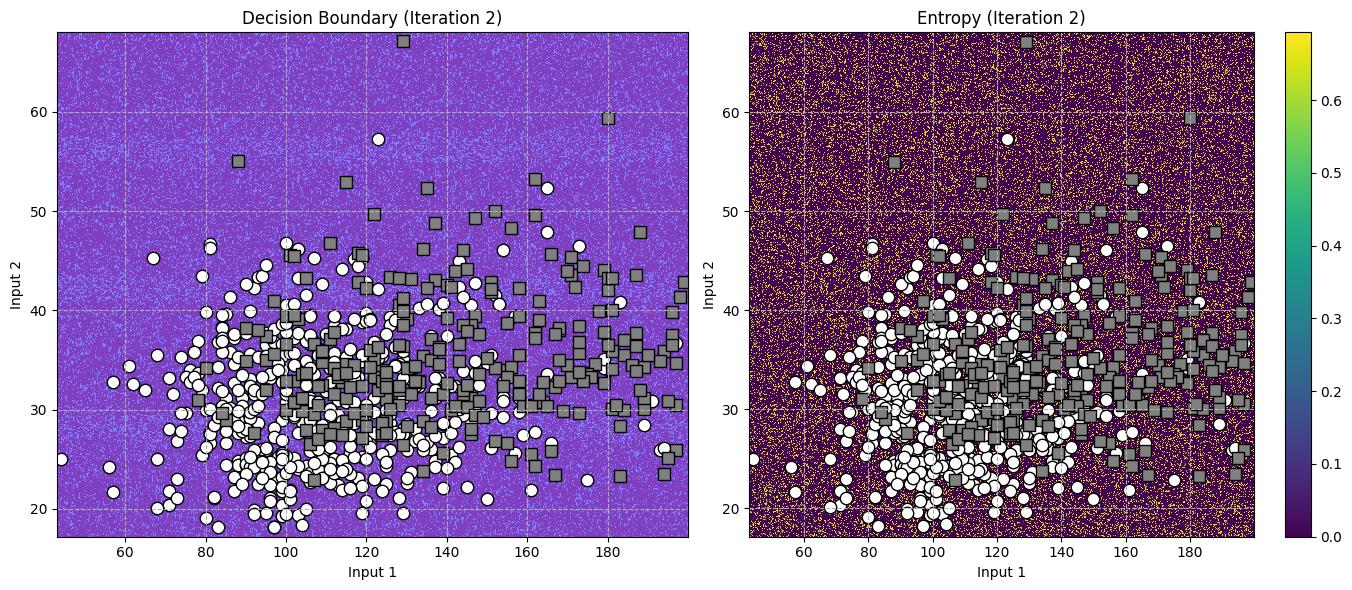

24973/24973 ━━━━━━━━━━━━━━━━━━━━ 6s 257us/step
tf.Tensor(
[[2.599862e-10]
 [1.000000e+00]
 [9.999976e-01]
 ...
 [1.000000e+00]
 [1.000000e+00]
 [1.000000e+00]], shape=(799130, 1), dtype=float32)


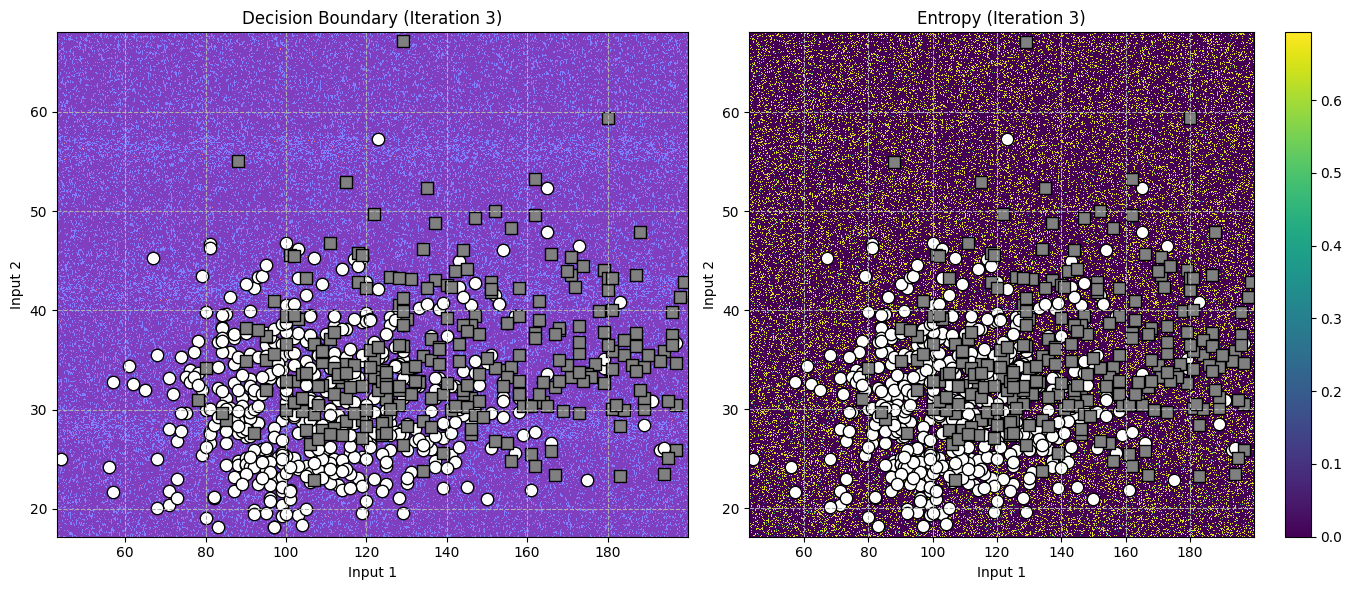

24973/24973 ━━━━━━━━━━━━━━━━━━━━ 7s 298us/step
tf.Tensor(
[[0.35497972]
 [1.        ]
 [0.99999356]
 ...
 [0.33711842]
 [1.        ]
 [0.34911606]], shape=(799130, 1), dtype=float32)


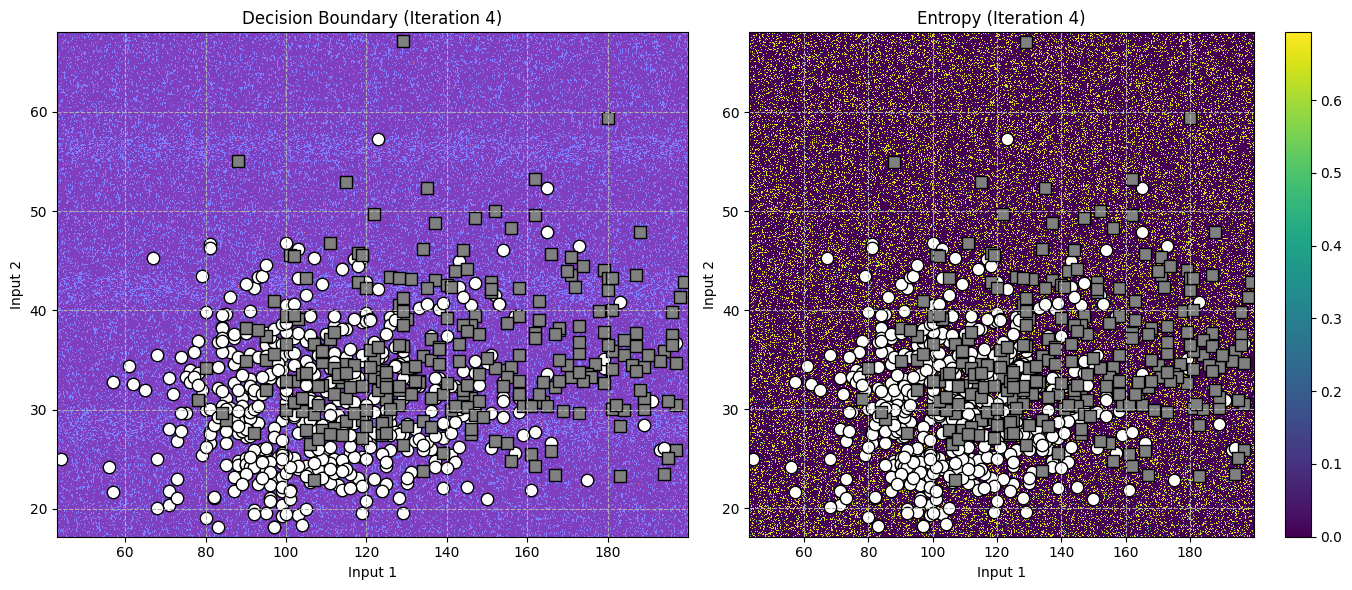

24973/24973 ━━━━━━━━━━━━━━━━━━━━ 7s 289us/step
tf.Tensor(
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]], shape=(799130, 1), dtype=float32)


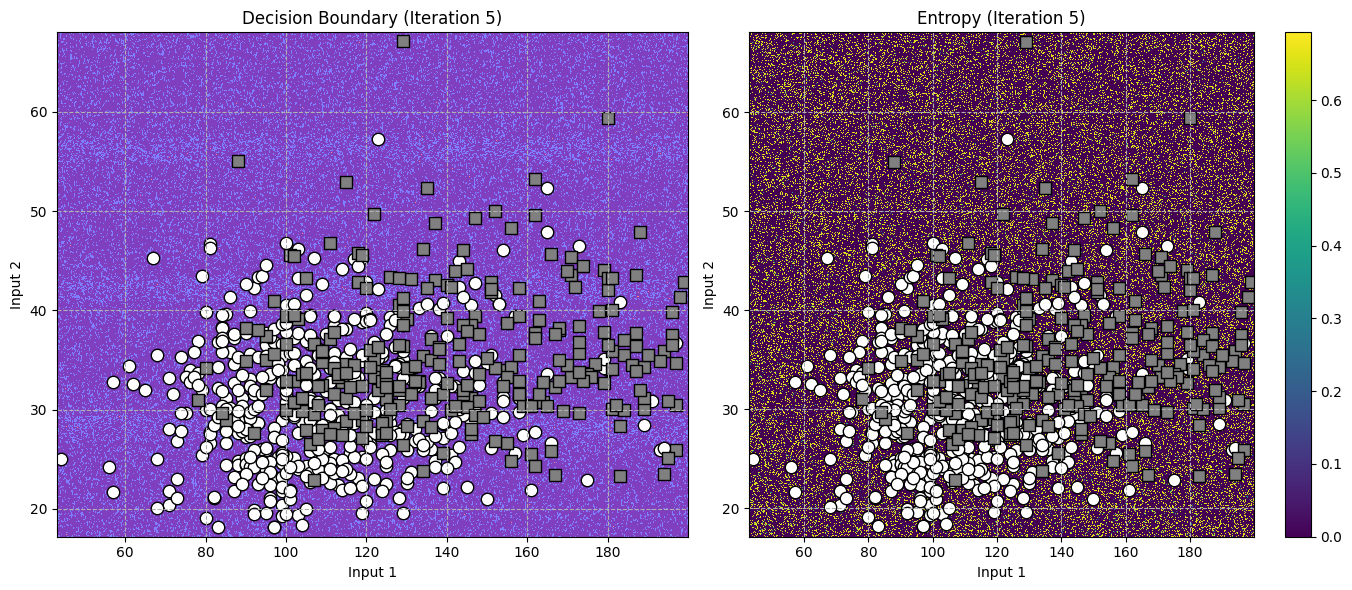

In [95]:
# Définir les limites de la grille en fonction de tes données (en supposant X est un numpy array avec 2 features)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
data_meshgrid = np.c_[xx.ravel(), yy.ravel()]

def get_entropy(prob: np.ndarray):
    # Convertir prob en TensorFlow tensor si nécessaire
    prob = tf.convert_to_tensor(prob, dtype=tf.float32)
    entropy = -prob * tf.math.log(prob) - (1 - prob) * tf.math.log(1 - prob)
    entropy = tf.where(tf.math.is_nan(entropy), tf.zeros_like(entropy), entropy)
    entropy = entropy.numpy()
    return entropy

# Nombre de passes pour MC Dropout
num_passes = 5
entropies = []

# Effectuer plusieurs passes pour obtenir les prédictions
for i in range(num_passes):
    model_predictions = model_MC.predict(data_meshgrid)
    probabilities = tf.sigmoid(model_predictions)
    print(probabilities)

    # Calculer l'entropie pour cette passe
    entropy = get_entropy(probabilities).reshape(xx.shape)
    entropies.append(entropy)

    # Créer un graphique pour l'itération actuelle
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Affichage de la frontière de décision
    pred = (probabilities.numpy() > 0.5).astype(int).reshape(xx.shape)
    # Affiche les zones colorées pour chaque classe
    ax1.contourf(xx, yy, pred, levels=[-0.1, 0.5, 1.1], colors=['red', 'blue'], alpha=0.5)
    ax1.set_xlabel("Input 1")
    ax1.set_ylabel("Input 2")
    ax1.set_title(f"Decision Boundary (Iteration {i + 1})")

    # Affichage de l'entropie
    im = ax2.pcolormesh(xx, yy, entropy, shading="auto")
    fig.colorbar(im, ax=ax2)
    ax2.set_xlabel("Input 1")
    ax2.set_ylabel("Input 2")
    ax2.set_title(f"Entropy (Iteration {i + 1})")

    for label, marker, color in zip([0, 1], ["o", "s"], ["white", "gray"]):
        _X = X[y == label]  # Filtrer les points par classe
        ax1.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors="black", marker=marker)
        ax2.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors="black", marker=marker)
    
    ax1.grid(linestyle="--")
    ax2.grid(linestyle="--")
    plt.tight_layout()
    plt.show()  # Afficher le graphique pour l'itération actuelle
